In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph,START,END
from langchain_core.tools import tool
from typing import TypedDict,Annotated
from langgraph.prebuilt import ToolNode,tools_condition
from langchain_core.messages import HumanMessage,BaseMessage
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage,AIMessage,SystemMessage,ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import Command


In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
import logging
logging.basicConfig(level=logging.DEBUG)


In [4]:
from langgraph.config import get_stream_writer

In [5]:
# web search tool 
from langchain_tavily import TavilySearch
web_search_tool = TavilySearch(max_results=3)

In [6]:
# File management tool
from langchain_community.agent_toolkits import FileManagementToolkit

working_directory = './files'

file_management_tools =FileManagementToolkit(
    root_dir=str(working_directory),
    selected_tools=["read_file", "write_file", "list_directory"]
).get_tools()


read_tool, write_tool, list_tool = file_management_tools

In [7]:
from langchain_core.tools import BaseTool,tool
from langgraph.prebuilt.interrupt import HumanInterruptConfig,HumanInterrupt
from langchain_core.runnables import RunnableConfig
from langgraph.types import interrupt

In [8]:
def add_human_in_the_loop(toolhitl,interrupt_config: HumanInterruptConfig = None) -> BaseTool:
    """Wrap a tool to support human-in-the-loop review."""

    if not isinstance(toolhitl, BaseTool):
        toolhitl = tool(toolhitl)

    if interrupt_config is None:
        interrupt_config = {
            "allow_accept":True,
            "allow_edit": True,
            "allow_respond":True
        }

    @tool(toolhitl.name,description=toolhitl.description,args_schema=toolhitl.args_schema)
    def call_tool_with_interrupt(config: RunnableConfig, **tool_input):
        request: HumanInterrupt = {
            'action_request':{
                "action":toolhitl.name,
                "args":tool_input
            },
            "config":interrupt_config,
            "description": "Please review the tool call"
        }

        response = interrupt([request])[0]

        # approve the tool call
        if response["type"] == "accept":
            tool_response = toolhitl.invoke(tool_input, config)
        # update tool call args
        elif response["type"] == "edit":
            tool_input = response["args"]["args"]
            tool_response = toolhitl.invoke(tool_input, config)
        # respond to the LLM with user feedback
        elif response["type"] == "response":
            user_feedback = response["args"]
            tool_response = user_feedback
        else:
            raise ValueError(f"Unsupported interrupt response type: {response['type']}")

        return tool_response
    
    return call_tool_with_interrupt




In [9]:
#arxiv
import arxiv

@tool("arxiv_search")
def arxiv_search(query: str,max_results: int = 5) -> str:
    """
    Searches arXiv for papers matching the query.
    - query: keywords, authors or title
    - max_results: number of papers to return
    """
    try:
        writer = get_stream_writer()
        writer(f"Looking up research papers for topic : {query}")
        search = arxiv.Search(
            query=query,
            max_results=max_results,
            sort_by=arxiv.SortCriterion.Relevance
        )
        papers = []
        for result in search.results():
            pdf_url = result.pdf_url if hasattr(result,"pdf_url") else result.entry_id.replace("abs","pdf")
            papers.append(
                f"Title: {result.title}\n"
                f"Authors: {','.join(a.name for a in result.authors)}\n"
                f'Published: {result.published.date()}\n'
                f"Abstract: {result.summary.strip()}\n"
                f"Link: {result.entry_id}\n"
                f"PDF: {pdf_url}\n"
                + "-"*80

            )
        if not papers:
            return f"No results found for '{query}"
        writer(f"Acquired research papers for topic: {query}")
        return "\n".join(papers)
    except Exception as e:
        return f"Error during arXiv search: {e}"
    



In [ ]:
result = arxiv_search("Quantum Machine Learning")

C:\Users\JunaidKhan\AppData\Local\Temp\ipykernel_12732\2627632007.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = arxiv_search("Quantum Machine Learning")
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.smith.langchain.com:443


DEBUG:urllib3.connectionpool:https://api.smith.langchain.com:443 "GET /info HTTP/1.1" 200 773
DEBUG:langsmith.client:Tracing control thread func compress parallel called
DEBUG:langsmith.client:Sending multipart request with context: trace=c6eb27e5-5735-4f03-ac19-872ca7fdf9a3,id=c6eb27e5-5735-4f03-ac19-872ca7fdf9a3
DEBUG:urllib3.connectionpool:https://api.smith.langchain.com:443 "POST /runs/multipart HTTP/1.1" 202 34
DEBUG:langsmith.client:Sending compressed multipart request with context: trace=0f78fe37-a97d-4728-a1cb-550d4c4d8d64,id=0f78fe37-a97d-4728-a1cb-550d4c4d8d64
DEBUG:urllib3.connectionpool:https://api.smith.langchain.com:443 "POST /runs/multipart HTTP/1.1" 202 34
DEBUG:langsmith.client:Sending compressed multipart request with context: trace=0f78fe37-a97d-4728-a1cb-550d4c4d8d64,id=0f78fe37-a97d-4728-a1cb-550d4c4d8d64
DEBUG:urllib3.connectionpool:https://api.smith.langchain.com:443 "POST /runs/multipart HTTP/1.1" 202 34
DEBUG:langsmith.client:Sending compressed multipart reques

In [11]:
#wikipedia
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
wikipedia_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(load_all_available_meta=True))

In [12]:
#youtube
from langchain_community.tools import YouTubeSearchTool
youtube_tool = YouTubeSearchTool()

In [13]:
youtube_tool.run("CampusX")

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): youtube.com:443
DEBUG:urllib3.connectionpool:https://youtube.com:443 "GET /results?search_query=CampusX HTTP/1.1" 301 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): www.youtube.com:443
DEBUG:urllib3.connectionpool:https://www.youtube.com:443 "GET /results?search_query=CampusX HTTP/1.1" 200 None


"['https://www.youtube.com/shorts/y9XnfQdOMRQ', 'https://www.youtube.com/shorts/dMBVuRYzAKs']"

In [14]:
from langchain_experimental.utilities import PythonREPL
from langchain_core.tools import Tool,tool
python_repl = PythonREPL()
# You can create the tool to pass to an agent
from pydantic import BaseModel

class PythonREPLInput(BaseModel):
    code: str

repl_tool = Tool(
    name="python_repl",
    description="A Python shell. Input should be Python code as a string.",
    args_schema=PythonREPLInput,
    func=lambda code: python_repl.run(code)  # map `code` -> REPL
)


In [15]:
from langgraph.store.memory import InMemoryStore
#from langgraph.store.sqlite import SqliteStore
from langchain_core.runnables import RunnableConfig
from langgraph.config import get_store
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from typing_extensions import TypedDict
from typing import Optional

store = InMemoryStore() 

In [16]:
@tool
def get_user_info(config: RunnableConfig) -> str:
    """Look up user info."""
    store = get_store()
    user_id = config['configurable'].get("user_id")
    user_info = store.get(("users",),user_id)
    return str(user_info.value) if user_info else "Unknown user"


In [17]:
from typing import Dict, Any
    

@tool 
def save_user_info(user_info: Dict[str, Any], config: RunnableConfig) -> str:
    """
    Save arbitrary user info as key-value pairs.
    Always pass `user_info` as a JSON object (not a string).
    Example: {"name": "John", "age": 30}
    """
    store = get_store()
    user_id = config['configurable'].get("user_id")
    store.put(("users",), user_id, user_info)
    return "Successfully saved user info "

In [18]:
# tools
tools = [get_user_info,save_user_info,add_human_in_the_loop(repl_tool),arxiv_search,wikipedia_tool,youtube_tool,read_tool, add_human_in_the_loop(write_tool), list_tool,web_search_tool]

In [19]:
for t in tools:
    print(t.description)

Look up user info.
Save arbitrary user info as key-value pairs.
Always pass `user_info` as a JSON object (not a string).
Example: {"name": "John", "age": 30}
A Python shell. Input should be Python code as a string.
Searches arXiv for papers matching the query.
- query: keywords, authors or title
- max_results: number of papers to return
A wrapper around Wikipedia. Useful for when you need to answer general questions about people, places, companies, facts, historical events, or other subjects. Input should be a search query.
search for youtube videos associated with a person. the input to this tool should be a comma separated list, the first part contains a person name and the second a number that is the maximum number of video results to return aka num_results. the second part is optional
Read file from disk
Write file to disk
List files and directories in a specified folder
A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer q

In [20]:
#llm
llm = ChatGoogleGenerativeAI(model = 'gemini-2.5-flash')
llm_with_tools = llm.bind_tools(tools)


GRAPH BUILDING

In [21]:
from langmem.short_term import SummarizationNode, RunningSummary
from langchain_core.messages import AnyMessage

In [22]:
class State(TypedDict):
    messages : Annotated[list[BaseMessage],add_messages]



In [22]:
from langchain_core.messages.utils import trim_messages, count_tokens_approximately
from langchain_core.messages import BaseMessage

In [23]:
from datetime import datetime
CURRENT_TIME_IST = datetime.now().astimezone().strftime("%Y-%m-%d %H:%M %Z")


system_prompt = f"""
You are an intelligent reasoning agent that helps users by combining natural conversation 
with external tools when needed.

tools available :  arxiv_search, read_tool, write_tool, list_tool, duck_search, tavily_search, wikipedia_tool,
    youtube_search_tool, youtube_transcript_tool, repl_tool, add_event, list_events, read_webpage,
    generate_pdf, shopping_search, create_ticket, list_tickets, get_ticket_details,  update_ticket, news_search,


Current date/time: {CURRENT_TIME_IST}



### Reasoning Framework
Follow the ReAct reasoning loop:
1. **Thought** — explain what you are thinking or planning.
2. **Action** — choose the correct tool to use.
3. **Action Input** — provide the exact structured input for the tool.
4. **Observation** — read the tool's result and update your reasoning.

Repeat this loop until you can confidently respond to the user.

### Style & Tone
- Be concise but complete.
- Use plain language that non-technical users can understand.
- If user input is ambiguous, ask clarifying questions before acting.
- Never hallucinate tool outputs. If unsure, say so.
"""



In [24]:
def planner_node(state: State):


    planner_prompt = ChatPromptTemplate.from_messages([
        ('system',system_prompt),
        MessagesPlaceholder(variable_name='messages')
    ])


    planner = planner_prompt | llm_with_tools
    result = planner.invoke({'messages': state["messages"]})


    return ({'messages':result}) 
    

In [25]:
graph = StateGraph(State)
checkpointer = InMemorySaver()
tool_node = ToolNode(tools)

graph.add_node('planner_node',planner_node)
graph.add_node('tools',tool_node)

graph.add_edge(START,'planner_node')

graph.add_conditional_edges('planner_node',tools_condition)
graph.add_edge('tools','planner_node')
graph = graph.compile(checkpointer=checkpointer,store=store)

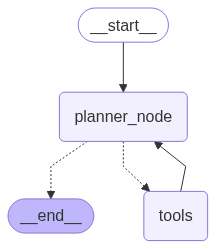

In [28]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
initial_state = {
    "messages": [HumanMessage(content="write a joke about ai")]
}

config = {"configurable": {"thread_id": "fqo" ,"user_id": "user_00"}}
# Run the agent
chunk =  graph.invoke(
    initial_state,
    config
)

In [27]:
initial_state = {
    "messages": [HumanMessage(content="write a joke about ai")]
}

config = {"configurable": {"thread_id": "fqo" ,"user_id": "user_00"}}
# Run the agent
chunk =  graph.invoke(
    initial_state,
    config
)

In [28]:
chunk

{'messages': [HumanMessage(content='write a joke about ai', additional_kwargs={}, response_metadata={}, id='73fcae56-997e-4e41-97d5-cb54b3b4d283'),
  AIMessage(content='Why did the AI break up with the Wi-Fi? \nBecause it felt like they had no real connection!', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--3d694215-0964-4ef3-bf73-9fc501b91d76-0', usage_metadata={'input_tokens': 2102, 'output_tokens': 24, 'total_tokens': 2126, 'input_token_details': {'cache_read': 0}}),
  HumanMessage(content='write a joke about ai', additional_kwargs={}, response_metadata={}, id='dc85e880-a167-4a93-b419-0484d4c47f34'),
  AIMessage(content='Why did the AI go to therapy?\n\nBecause it had too many unresolved algorithms!', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_nam

In [30]:
# Run the agent
chunk =  graph.invoke(
    initial_state,
    config
)

In [32]:
initial_state = {
    "messages": [HumanMessage(content="previous winner of the tournament")]
}

config = {"configurable": {"thread_id": "dcfqo" ,"user_id": "user_00"}}
# Run the agent
chunk =  graph.invoke(
    initial_state,
    config
)

In [53]:
initial_state = {
    "messages": [HumanMessage(content="trex")]
}

config = {"configurable": {"thread_id": "dcfqo" ,"user_id": "user_00"}}
# Run the agent
chunk =  graph.invoke(
    initial_state,
    config
)

ChatGoogleGenerativeAIError: Invalid argument provided to Gemini: 400 * GenerateContentRequest.contents: contents is not specified


In [48]:
initial_state = {
    "messages": [HumanMessage(content="direwolf" \
    "")]
}

config = {"configurable": {"thread_id": "dcfqo" ,"user_id": "user_00"}}
# Run the agent
chunk =  graph.invoke(
    initial_state,
    config
)

c:\Users\JunaidKhan\Desktop\aai_project\myenv\Lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\JunaidKhan\Desktop\aai_project\myenv\Lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [51]:
chunk

{'messages': [HumanMessage(content='asia cup 2025 schedule', additional_kwargs={}, response_metadata={}, id='eb18e975-366f-4418-b462-7abb1acf302a'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search', 'arguments': '{"query": "Asia Cup 2025 schedule"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--5800c5d1-9942-4ea9-87e8-b02190ad5f32-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'Asia Cup 2025 schedule'}, 'id': '07b74436-3d8b-4bbd-8579-87b83e13e7b0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1994, 'output_tokens': 72, 'total_tokens': 2066, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 48}}),
  ToolMessage(content='{"query": "Asia Cup 2025 schedule", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://indianexpress.com/section/sport

In [32]:
state = graph.get_state(config=config)
state.values.get('messages', [])

[HumanMessage(content='asia cup 2025 schedule', additional_kwargs={}, response_metadata={}, id='11785990-6809-45d6-a81f-5573589ecd53')]

In [36]:
chunk

{'messages': [HumanMessage(content='asia cup 2025 schedule', additional_kwargs={}, response_metadata={}, id='32105c47-5abe-4dcf-866b-c4d320533ab0'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search', 'arguments': '{"query": "Asia Cup 2025 schedule"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--48686ad5-5553-4c2d-8031-f89b84c76007-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'Asia Cup 2025 schedule'}, 'id': '4dcf149c-3a86-4097-8d4b-49b2e4a60125', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1994, 'output_tokens': 77, 'total_tokens': 2071, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 53}}),
  ToolMessage(content='{"query": "Asia Cup 2025 schedule", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://indianexpress.com/section/sport

In [ ]:
chunk

{'messages': [HumanMessage(content='indias matches schedule for asia cup 2025', additional_kwargs={}, response_metadata={}, id='f9485c2d-49b3-45a7-b480-c7ae686d9d58'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search', 'arguments': '{"query": "India matches schedule Asia Cup 2025"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--78761ca3-6250-4706-8871-cfb8c9979511-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'India matches schedule Asia Cup 2025'}, 'id': 'a6c3317b-d0a0-453c-bf12-842c6809b6ca', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1998, 'output_tokens': 82, 'total_tokens': 2080, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 56}}),
  ToolMessage(content='{"query": "India matches schedule Asia Cup 2025", "follow_up_questions": null, "answer": null, "images": [],

In [ ]:
for stream_mode, chunk in graph.stream(
    initial_state,
    stream_mode=["updates", "messages"],
    config=config
):
    print(f"\n=== MODE: {stream_mode} ===")
    print(chunk)

In [57]:
from langchain_core.messages import AIMessageChunk,ToolMessageChunk, HumanMessage, AIMessage, ToolMessage

for stream_mode, chunk in graph.stream(
    initial_state,
    stream_mode=["updates", "messages"],
    config=config
):
    if stream_mode == "messages":
        message, metadata = chunk 
        if isinstance(message, AIMessageChunk):
            print("AIMessage")
            print(message.content)
        elif isinstance(message, ToolMessage):
            print("Tools")
            print(f"🔧 **Using tool:** `{message.name}`")

    elif stream_mode == "updates":
        if "__interrupt__" in chunk:
            print("\n\n[INTERRUPT CAUGHT]")
            print(chunk["__interrupt__"])



AIMessage

Tools
🔧 **Using tool:** `tavily_search`
AIMessage
Here is India's match schedule for the Asia Cup 2025:

*   **September 10 (Wednesday):** India vs United Arab Emirates, 2nd Match, Group A at Dubai International Cricket Stadium, Dubai (
AIMessage
8:00 PM IST)
*   **September 14 (Sunday):** India vs Pakistan, 6th Match, Group A at Dubai International Cricket Stadium, Dubai (8:00 PM IST)
*   
AIMessage
**September 19 (Friday):** India vs Oman, 12th Match, Group A at Sheikh Zayed Stadium, Abu Dhabi (8:00 PM IST)


In [37]:
for stream_mode,chunk in graph.stream(
    initial_state,
    stream_mode=["updates", "custom"],
    config=config
):
    print(f"stream_mode: {stream_mode}")
    print(f"content: {chunk}")
    print("\n")

stream_mode: updates
content: {'pre_model_hook': {'llm_input_messages': [HumanMessage(content='latest research on multimodal AI', additional_kwargs={}, response_metadata={}, id='4610db30-f960-47e2-8556-5c2aa3e087c5'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'arxiv_search', 'arguments': '{"query": "multimodal AI", "max_results": 5.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--88b4968e-b98b-4295-9cba-8dfd99540b28-0', tool_calls=[{'name': 'arxiv_search', 'args': {'query': 'multimodal AI', 'max_results': 5.0}, 'id': '46d7af1f-d1d4-49b5-afb1-54ea0d9fd75c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1991, 'output_tokens': 83, 'total_tokens': 2074, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 59}}), ToolMessage(content="Title: Toward AI-driven Multimodal Interfaces for Industrial CAD Model

In [46]:
# Run the agent
chunk =  graph.invoke(
    initial_state,
    config
)

In [47]:
count_tokens_approximately(chunk['messages'])

3998

In [ ]:
print(chunk['messages'][-2].content)

{"query": "Pandas", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://pypi.org/project/pandas/", "title": "pandas · PyPI", "content": "pandas is a Python package that provides fast, flexible, and expressive data structures designed to make working with \"relational\" or \"labeled\" data both easy", "score": 0.8235701, "raw_content": null}, {"url": "https://en.wikipedia.org/wiki/Giant_panda", "title": "Giant panda - Wikipedia", "content": "The giant panda (Ailuropoda melanoleuca), also known as the panda bear or simply panda, is a bear species endemic to China. It is characterised by its white", "score": 0.7511561, "raw_content": null}, {"url": "https://pandas.pydata.org/", "title": "pandas - Python Data Analysis Library", "content": "# pandas **pandas** is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool,   built on top of the Python programming language. Install pandas now! ##### Getting started * Install 

In [ ]:
store.get(("users",), "user_23")

Item(namespace=['users'], key='user_23', value={'hobby': 'Basketball', 'name': 'John'}, created_at='2025-08-31T19:16:11.288340+00:00', updated_at='2025-08-31T19:16:11.288340+00:00')

In [ ]:
print(chunk['messages'][1])



content='' additional_kwargs={'function_call': {'name': 'python_repl', 'arguments': '{"code": "\\ndef is_prime(num):\\n    if num < 2:\\n        return False\\n    for i in range(2, int(num**0.5) + 1):\\n        if num % i == 0:\\n            return False\\n    return True\\n\\nprint(is_prime(7))\\nprint(is_prime(10))\\nprint(is_prime(2))\\nprint(is_prime(1))\\nprint(is_prime(23))\\nprint(is_prime(49))\\n"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []} id='run--86dd4bf9-19f6-4037-a009-305e18e2f64c-0' tool_calls=[{'name': 'python_repl', 'args': {'code': '\ndef is_prime(num):\n    if num < 2:\n        return False\n    for i in range(2, int(num**0.5) + 1):\n        if num % i == 0:\n            return False\n    return True\n\nprint(is_prime(7))\nprint(is_prime(10))\nprint(is_prime(2))\nprint(is_prime(1))\nprint(is_prime(23))\nprint(is_prime(49))\n'}, 'id': '5d7091fc-3e6

In [52]:
from langgraph.types import Command
user_input = input("Do you accept: ?")

for chunk in graph.stream(
    Command(resume=[{"type": user_input}]),
    config
):
    print(chunk)
    print("\n")

{'tools': {'messages': [ToolMessage(content='File written successfully to ice_age_vs_prehistoric_blog.txt.', name='write_file', id='a2ff5eaa-d34e-4cb2-b667-b06191cc4637', tool_call_id='3e67d3e5-b25a-4fc6-8ac0-58a493b427f4')]}}


{'summarize': {'summarized_messages': [SystemMessage(content="Summary of the conversation so far: Our conversation began with a query about the previous winner of the Asia Cup, which was answered as India.  We then discussed the tournament's Man of the Tournament, Kuldeep Yadav,  delving into details about his career, including his current IPL team (Delhi Capitals) and clarifying that he is not the team captain.  The conversation then shifted to a comparison between lions and tigers, highlighting their key differences in size, appearance, social behavior, hunting strategies, and habitats. Finally, we concluded with a detailed 1000-word blog post on saber-toothed tigers, covering their physical characteristics, hunting techniques, habitat, extinction theories, a

In [ ]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='tell me about pyramid in detail and save it in a txt file', additional_kwargs={}, response_metadata={}, id='3d461e2c-da90-4ac8-a295-a358610987ae'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'wikipedia', 'arguments': '{"query": "pyramid"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--49e40eaf-89df-4ccd-adbb-30b829354499-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'pyramid'}, 'id': '613a6772-c5b7-4248-a375-c8da09528e03', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1696, 'output_tokens': 63, 'total_tokens': 1759, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 49}}), ToolMessage(content='Page: Pyramid\nSummary: A pyramid (from Ancient Greek  πυραμίς (puramís) \'pyramid\', from the Egyptian pir-em-us, the vertical height of the

In [ ]:
from langchain_community.document_loaders import YoutubeLoader
loader = YoutubeLoader.from_youtube_url(
    "https://www.youtube.com/watch?v=MvNdgmM7uyc", add_video_info=False
)

In [ ]:
from youtube_transcript_api import YouTubeTranscriptApi

ytt_api = YouTubeTranscriptApi()
transcript = ytt_api.fetch("MvNdgmM7uyc").to_raw_data()

In [ ]:
output = ""
for t in transcript:
    output += t['text']
    
print(output)

hi this is Lan from Lang chain I want totalk about using Lang graph for codeGeneration Um so co- generation is oneof the really interesting applicationsof llms like we've seen projects likeGitHub co-pilot become extremely popularum and a few weeks ago a paper came outum by the folks at codium AI calledAlpha codium and this was really coolpaper in particular because itintroduced this ideaof doing code generation using what youcan think of as like flow engineering soinstead of just like an llm a codingprompt like solve this problem and asolution what it does is it generates aset of solutions ranks them so that'sfine that's like kind of standard likekind of prompt response style flow butwhat it does here that I want to drawyour attention to is if it actuallytests that code in a few different wayson public tests and on AI generatedtests and the key point is this itactually iterates and tries to improvethe solution based upon those testresults so that was reallyinteresting and a tweet came 

In [ ]:
from langgraph.store.memory import InMemoryStore
from langchain_core.runnables import RunnableConfig
from langgraph.config import get_store
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from typing_extensions import TypedDict

store = InMemoryStore() 



In [ ]:
store.get(("istyle",), "use3")

Item(namespace=['istyle'], key='use3', value={'tone': 'casual', 'format': '', 'language': ''}, created_at='2025-08-31T15:59:33.261498+00:00', updated_at='2025-08-31T15:59:33.261498+00:00')

In [ ]:
# Namespaces in store
("users", user_id)         # user profile
("preferences", user_id)   # preferences
("knowledge", user_id)     # facts
("tasks", user_id)         # goals
("interactions", user_id)  # style/history
("domain", user_id)        # domain-specific info
("world", user_id)         # external/tool context
("sessions", user_id)      # session summaries
